# Data Mining Novel Chart Patterns With Python

Using perceptually important points combined with unsupervised learning to find unique chart patterns for trading using python. We cluster the price structure patterns and select the high performing patterns using the martin ratio as an objective function.  We perform a monte carlo permutation test to verify the results. We also perform a walkforward test. 

* Tutorial: [Data Mining Novel Chart Patterns With Python | Algorithmic Trading Strategy](https://www.youtube.com/watch?v=P4u5drToePM)
* Full Code: https://github.com/neurotrader888/TechnicalAnalysisAutomation

Citations
- Chung, F.L., Fu, T.C., Luk, R., Ng, V., Flexible Time Series Pattern Matching Based on Perceptually Important Points. In: Workshop on Learning from Temporal and Spatial Data at IJCAI (2001) 1-7

- Keogh, E., Lin, J., Truppel, W.: Clustering of Time Series Subsequences is Meaningless: Implications for Previous and Future Research. Proc. of ICDM, (2003) 115-122

- Fu, Tc., Chung, Fl., Luk, R., Ng, Cm. (2005). Preventing Meaningless Stock Time Series Pattern Discovery by Changing Perceptually Important Point Detection. In: Wang, L., Jin, Y. (eds) Fuzzy Systems and Knowledge Discovery. FSKD 2005. Lecture Notes in Computer Science(), vol 3613. Springer, Berlin, Heidelberg.

- Peter Rousseeuw. Silhouettes: A graphical aid to the interpretation and validation of cluster analysis. J. Comput. Appl. Math., 20(1):53–65, November 1987.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import mplfinance as mpf
from tqdm import tqdm
from pyclustering.cluster.silhouette import silhouette_ksearch_type, silhouette_ksearch
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from src.perceptually_important import find_pips

In [2]:
class PIPPatternMiner:

    def __init__(self, n_pips: int, lookback: int, hold_period: int):
        self._n_pips = n_pips
        self._lookback = lookback
        self._hold_period = hold_period
        
        self._unique_pip_patterns = []
        self._unique_pip_indices = []
        self._cluster_centers = []
        self._pip_clusters = []

        self._cluster_signals = []
        self._cluster_objs = []

        self._long_signal = None
        self._short_signal = None

        self._selected_long = []
        self._selected_short = []

        self._fit_martin = None
        self._perm_martins = []
        
        self._data = None # Array of log closing prices to mine patterns
        self._returns = None # Array of next log returns, concurrent with _data

    def get_fit_martin(self):
        return self._fit_martin

    def get_permutation_martins(self):
        return self._perm_martins

    def plot_cluster_examples(self, candle_data: pd.DataFrame, cluster_i: int, grid_size: int = 5):
        plt.style.use('dark_background')
        fig, axs = plt.subplots(grid_size, grid_size)
        flat_axs = axs.flatten()
        for i in range(len(flat_axs)):
            if i >= len(self._pip_clusters[cluster_i]):
                break
            
            pat_i = self._unique_pip_indices[self._pip_clusters[cluster_i][i]]
            data_slice = candle_data.iloc[pat_i - self._lookback + 1: pat_i + 1]
            idx = data_slice.index
            plot_pip_x, plot_pip_y = find_pips(data_slice['close'].to_numpy(), self._n_pips, 3)
            
            pip_lines = []
            colors = []
            for line_i in range(self._n_pips - 1):
                l0 = [(idx[plot_pip_x[line_i]], plot_pip_y[line_i]), (idx[plot_pip_x[line_i + 1]], plot_pip_y[line_i + 1])]
                pip_lines.append(l0)
                colors.append('w')

            mpf.plot(data_slice, type='candle',alines=dict(alines=pip_lines, colors=colors), ax=flat_axs[i], style='charles', update_width_config=dict(candle_linewidth=1.75) )
            flat_axs[i].set_yticklabels([])
            flat_axs[i].set_xticklabels([])
            flat_axs[i].set_xticks([])
            flat_axs[i].set_yticks([])
            flat_axs[i].set_ylabel("")

        fig.suptitle(f"Cluster {cluster_i}", fontsize=32)
        plt.show()


    def predict(self, pips_y: list):
        norm_y = (np.array(pips_y) - np.mean(pips_y)) / np.std(pips_y)

        # Find cluster
        best_dist = 1.e30
        best_clust = -1
        for clust_i in range(len(self._cluster_centers)):
            center = np.array(self._cluster_centers[clust_i])
            dist = np.linalg.norm(norm_y-center)
            if dist < best_dist:
                best_dist = dist
                best_clust = clust_i

        if best_clust in self._selected_long:
            return 1.0
        elif best_clust in self._selected_short:
            return -1.0
        else:
            return 0.0
    
    
    def train(self, arr: np.array, n_reps=-1):
        self._data = arr
        self._returns = pd.Series(arr).diff().shift(-1)
        self._find_unique_patterns()
        

        search_instance = silhouette_ksearch(
                self._unique_pip_patterns, 5, 40, algorithm=silhouette_ksearch_type.KMEANS).process()
        
        amount = search_instance.get_amount()
        self._kmeans_cluster_patterns(amount)

        self._get_cluster_signals()
        self._assign_clusters()
        self._fit_martin = self._get_total_performance()
        
        print(f"fit_martin: {self._fit_martin}")

        if n_reps <= 1:
            return

        # Start monte carlo permutation test
        data_copy = self._data.copy()
        returns_copy = self._returns.copy()

        for rep in tqdm(range(1, n_reps + 1), desc="monte carlo test"):
            x = np.diff(data_copy).copy()
            np.random.shuffle(x)
            x = np.concatenate([np.array([data_copy[0]]), x])
            self._data = np.cumsum(x)
            self._returns = pd.Series(self._data).diff().shift(-1)
            # print("rep", rep) 
            self._find_unique_patterns()
            search_instance = silhouette_ksearch(
                    self._unique_pip_patterns, 5, 40, algorithm=silhouette_ksearch_type.KMEANS).process()
            amount = search_instance.get_amount()
            self._kmeans_cluster_patterns(amount)
            self._get_cluster_signals()
            self._assign_clusters()
            perm_martin = self._get_total_performance()
            self._perm_martins.append(perm_martin)


    def _find_unique_patterns(self):
        # Find unique pip patterns in data
        self._unique_pip_indices.clear()
        self._unique_pip_patterns.clear()
        
        last_pips_x = [0] * self._n_pips
        for i in range(self._lookback - 1, len(self._data) - self._hold_period):
            start_i = i - self._lookback + 1
            window = self._data[start_i: i + 1]
            pips_x, pips_y = find_pips(window, self._n_pips, 3)
            pips_x = [j + start_i for j in pips_x]

            # Check internal pips to see if it is the same as last
            same = True
            for j in range(1, self._n_pips - 1):
                if pips_x[j] != last_pips_x[j]:
                    same = False
                    break
            
            if not same:
                # Z-Score normalize pattern
                pips_y = list((np.array(pips_y) - np.mean(pips_y)) / np.std(pips_y))
                self._unique_pip_patterns.append(pips_y)
                self._unique_pip_indices.append(i)

            last_pips_x = pips_x


    def _kmeans_cluster_patterns(self, amount_clusters):
        # Cluster Patterns
        initial_centers = kmeans_plusplus_initializer(self._unique_pip_patterns, amount_clusters).initialize()
        kmeans_instance = kmeans(self._unique_pip_patterns, initial_centers)
        kmeans_instance.process()

        # Extract clustering results: clusters and their centers
        self._pip_clusters = kmeans_instance.get_clusters()
        self._cluster_centers = kmeans_instance.get_centers()

    def _get_martin(self, rets: np.array):
        rsum = np.sum(rets)
        short = False
        if rsum < 0.0:
            rets *= -1
            rsum *= -1
            short = True

        csum = np.cumsum(rets)
        eq = pd.Series(np.exp(csum))
        sumsq = np.sum( ((eq / eq.cummax()) - 1) ** 2.0 )
        ulcer_index = (sumsq / len(rets)) ** 0.5
        martin = rsum / ulcer_index
        if short:
            martin = -martin

        return martin

    def _get_cluster_signals(self):
        self._cluster_signals.clear()

        for clust in self._pip_clusters: # Loop through each cluster
            signal = np.zeros(len(self._data))
            for mem in clust: # Loop through each member in cluster
                arr_i = self._unique_pip_indices[mem]
                
                # Fill signal with 1s following pattern identification
                # for hold period specified
                signal[arr_i: arr_i + self._hold_period] = 1. 
            
            self._cluster_signals.append(signal)

    def _assign_clusters(self):
        self._selected_long.clear()
        self._selected_short.clear()
        
        # Assign clusters to long/short/neutral
        cluster_martins = []
        for clust_i in range(len(self._pip_clusters)): # Loop through each cluster
            sig = self._cluster_signals[clust_i]
            sig_ret = self._returns * sig
            martin = self._get_martin(sig_ret)
            cluster_martins.append(martin)

        best_long = np.argmax(cluster_martins)
        best_short = np.argmin(cluster_martins)
        self._selected_long.append(best_long)
        self._selected_short.append(best_short)

    def _get_total_performance(self):

        long_signal = np.zeros(len(self._data))
        short_signal = np.zeros(len(self._data))

        for clust_i in range(len(self._pip_clusters)):
            if clust_i in self._selected_long:
                long_signal += self._cluster_signals[clust_i]
            elif clust_i in self._selected_short:
                short_signal += self._cluster_signals[clust_i]
        
        long_signal /= len(self._selected_long)
        short_signal /= len(self._selected_short)
        short_signal *= -1

        self._long_signal = long_signal
        self._short_signal = short_signal
        rets = (long_signal + short_signal) * self._returns

        martin = self._get_martin(rets)
        return martin

In [3]:
## Load data
data = pd.read_csv('src/BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')
data = np.log(data)

In [4]:
## Main

plt.style.use('dark_background')

data = data[data.index < '01-01-2020']
arr = data['close'].to_numpy()
pip_miner = PIPPatternMiner(n_pips=5, lookback=24, hold_period=6)
pip_miner.train(arr, n_reps=-1)

# Monte Carlo test, takes about an hour..
pip_miner.train(arr, n_reps=100)

fit_martin: 26.774242711056765
fit_martin: 42.8211093423151


monte carlo test: 100%|█████████████████████| 100/100 [29:18<00:00, 17.58s/it]


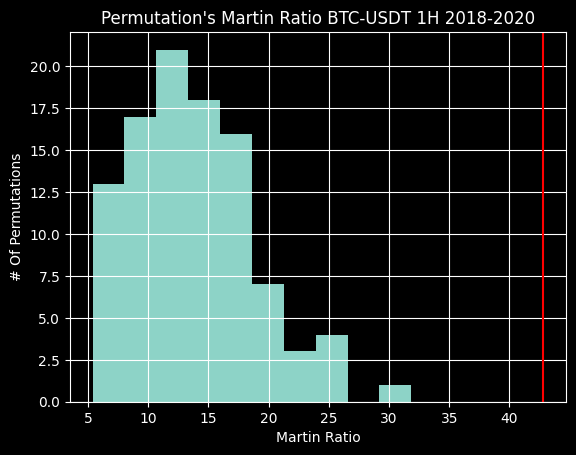

In [5]:
plt.style.use('dark_background')
actual_martin = pip_miner.get_fit_martin()
perm_martins = pip_miner.get_permutation_martins()
ax = pd.Series(perm_martins).hist()
ax.set_ylabel("# Of Permutations")
ax.set_xlabel("Martin Ratio")
ax.set_title("Permutation's Martin Ratio BTC-USDT 1H 2018-2020")
ax.axvline(actual_martin, color='red')
plt.show()

#### Walk Forward Test

In [6]:
class WFPIPMiner:

    def __init__(self, n_pips: int, lookback: int, hold_period: int, train_size: int, step_size: int):
        self._n_pips = n_pips
        self._lookback = lookback
        self._hold_period = hold_period
        self._train_size = train_size
        self._step_size = step_size

        self._next_train = train_size - 1
        self._trained = False

        self._curr_sig = 0.0
        self._curr_hp = 0

        self._pip_miner = PIPPatternMiner(n_pips, lookback, hold_period)
    
    def update_signal(self, arr: np.array, i:int) -> float:
        if i >= self._next_train:
            self._pip_miner.train(arr[i - self._next_train + 1: i + 1 ])
            self._next_train += self._step_size
            self._trained = True

        if not self._trained:
            return 0.0

        if self._curr_hp > 0:
            self._curr_hp -= 1

        if self._curr_hp == 0:
            self._curr_sig = 0.0

        pips_x, pips_y = find_pips( arr[i - self._lookback + 1: i+1], self._n_pips, 3)
        pred = self._pip_miner.predict(pips_y)
        if pred != 0.0:
            self._curr_sig = pred
            self._curr_hp = self._hold_period
        
        return self._curr_sig

In [7]:
data = pd.read_csv('src/BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')
data = np.log(data)

In [8]:
arr = data['close'].to_numpy()
wf_miner = WFPIPMiner(
    n_pips=5, 
    lookback=24, 
    hold_period=6, 
    train_size=24 * 365 * 2, 
    step_size=24 * 365 * 1
)
    
sig = [0] * len(arr)
for i in range(len(arr)):
    sig[i] = wf_miner.update_signal(arr, i)

data['sig'] = sig
data['r'] = data['close'].diff().shift(-1)
data['sig_r'] = data['sig'] * data['r']

fit_martin: 25.139668179317475
fit_martin: 40.29958815562518
fit_martin: 43.82848707482212
